# CZ3005 Project 1 - Balancing a Pole on a Cart

## Contribution: 
### Zon Liew (U1921098F): Task 1, Task 4 
### Paul Low (U2022421F): Task 2
### Charlotte Teo (U2022021G): Task 3, Task 4 

Running Instructions:<br>
Open the notebook in Google Colab <br>
Upload the 2 model files in the zip file into Colab<br>
Run the notebook from top to bottom<br>

Objectives:<br>
Apply Linear annealed policy with the EpsGreedyQPolicy as the inner policy:<br>
Achieve a DQN model that trains in reasonable possible number of episodes.<br>
Balance pole on the cart for 500 steps for 100 consecutive episodes while testing.<br>

Epsilon-Greedy chooses the optimal action at each step, but sometimes randomly chooses an unlikely option.<br>
We specify an initially high exploration rate (epsilon) of 1 at the beginning of Q function training because we know nothing about the importance of the Q table. Epsilon value is decreased as the agent has more confidence in the Q values.<br>

A DQN agent can be used in any environment which has a discrete action space.<br>
It is based on the Q - Network, a neural network model that can learn to predict Q-Values (expected returns) for all actions, given an observation from the environment.<br>


# Task 1
### Development of an RL agent

## Install Dependencies

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&z

#Install keras rl2 which seamlessly integrates with the  OpenAI Gym  to evaluate and play around with DQN Algorithm
!pip install rl-agents==0.1.1
!pip install keras-rl2
!pip install dopamine-rl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 63.3 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: z: ambiguous redirect


## Import Dependencies, Define Helper Functions

In [2]:
import gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

import keras
from keras import Sequential
from keras.layers import Input, Flatten, Dense
from rl.memory import SequentialMemory
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from tensorflow.keras.optimizers import Adam

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Load Cartpole Environment

In [5]:
#Load the CartPole environment from the OpenAI Gym suite
env = gym.make("CartPole-v1")

Each round of the pole-balancing game is an episode. At the start of each episode, ensure the environment is reset, which chooses a random initial state.

In [6]:
#Resets the environment to an initial state and returns the initial observation.
initial_observation = env.reset()
print("Initial observation:", initial_observation)
cumulative_reward = 0
done = False


Initial observation: [-0.03037836 -0.04453874 -0.00517983 -0.02098167]


Observation corresponds to 'cart position', 'cart velocity', 'pole angle', and 'angular velocity' respectively.

## Build Agent

### Setup of Deep Q-Network (DQN) agent using Keras-RL library
We use DQN because calculating, storing, and updating the Q-values after each action is extremely inefficient.<br>
Instead of a Q-table, we use neural networks to approximate the action-value function, in order to estimate the Q-values for each action.<br>
We evaluate the loss function without a labelled dataset using bootstrapping: estimating the current action value Q(s, a) by estimating the future Q(s’, a) value.<br>

Important functions used include:<br>
1. SequentialMemory: This sets up an experience replay buffer with a capacity limit of 50,000 and a window length of 1. The buffer stores the agent's experiences (state(S), action(A), reward(R), future state(S’)) so that they can be randomly sampled during the training process.
2. LinearAnnealedPolicy: This sets up the exploration policy for the agent. The LinearAnnealedPolicy computes a current threshold value and transfers it to an inner policy which chooses the action. The threshold value follows a linear function which decreases over time, hence gradually decreasing the exploration rate (eps) from 1.0 to 0.1 over 10,000 steps. It uses the EpsGreedyQPolicy as the inner policy, which randomly selects an exploration/exploitation action in each step. Epsilon is the small probability of the agent choosing to explore and select a random action. Otherwise, the agent selects the action with the highest estimated reward.
3. Sequential: This sets up a feed-forward neural network model for the DQN. It has an input layer with a shape of (1, env.observation_space.shape[0]), which means it takes in a single observation vector of length env.observation_space.shape[0]. The hidden layers have 256 and 128 nodes respectively and use the ReLU activation function. The output layer has a number of nodes equal to the number of actions in the action space, and uses the linear activation function.
4. DQNAgent: This sets up the DQN agent using the previously defined model, memory, policy, and other hyperparameters such as the number of warmup steps=25 and the target model update rate=1E-2. The enable_dueling_network argument is set to True, which means the agent will use a dueling architecture to estimate the Q-values of each action.
5. dqn.compile: Agent is compile with Adam optimizer, an extension to stochastic gradient descent. This optimization algorithm is time/space efficient, and require little parameter tuning.

From experimentation, we found that the given number of hidden layers/nodes, optimization parameters, and metrics used below were sufficient to train a successful model within a reasonable amount of time.

In [7]:
#Building DQN Agent with Keras-RL
# setup experience replay buffer
memory = SequentialMemory(limit=50000, window_length=1)

# setup the Linear annealed policy with the EpsGreedyQPolicy as the inner policy
policy =  LinearAnnealedPolicy(inner_policy=  EpsGreedyQPolicy(),   # policy used to select actions
                               attr='eps',                          # attribute in the inner policy to vary             
                               value_max=1.0,                       # maximum value of attribute that is varying
                               value_min=0.1,                       # minimum value of attribute that is varying
                               value_test=0.05,                     # test if the value selected is < 0.05
                               nb_steps=10000)                      # the number of steps between value_max and value_min

#Feed-Forward Neural Network Model for Deep Q Learning (DQN)
model = Sequential()
#print(env.observation_space)
#Input is 1 observation vector, and the number of observations(2) in that vector 
model.add(Input(shape=(1,env.observation_space.shape[0])))
model.add(Flatten())
#Hidden layers 
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
#Output is the number of actions in the action space
model.add(Dense(env.action_space.n, activation='linear')) 


#Feed-Forward Neural Network Architecture Summary
print(model.summary())

#Defining DQN Agent for DQN Model
dqn = DQNAgent(model=model,                     # Q-Network model
               nb_actions=env.action_space.n,   # number of actions
               memory=memory,                   # experience replay memory
               nb_steps_warmup=25,              # how many steps are waited before starting experience replay
               target_model_update=1e-2,        # how often the target network is updated
               policy=policy,                   # the action selection policy
              enable_dueling_network=True)                   

# Configure and compile agent. 
#Use built-in tensorflow.keras Adam optimizer and evaluation metrics            
#Adam._name = 'Adam'
dqn.compile(keras.optimizers.Adam(learning_rate=2.5e-4,epsilon = 0.01), metrics = ["mse",'accuracy'])



     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 256)               1280      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 34,434
Trainable params: 34,434
Non-trainable params: 0
_________________________________________________________________
None


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Train Agent 

In [8]:
#Finally fit and train the agent
#Verbose parameter controls how much information is printed during training. A value of 10 means that training progress is printed every 10 steps.
history = dqn.fit(env, nb_steps=5000, visualize=False, verbose=10)


/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Training for 5000 steps ...
   18/5000: episode: 1, duration: 0.188s, episode steps:  18, steps per second:  96, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.722 [0.000, 1.000],  loss: --, mse: --, accuracy: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.9/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 26 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 27 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)

   34/5000: episode: 2, duration: 0.826s, episode steps:  16, steps per second:  19, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.250 [0.000, 1.000],  loss: 0.544180, mse: 0.555977, accuracy: 0.394531, mean_q: 0.110689, mean_eps: 0.997345
   47/5000: episode: 3, duration: 0.096s, episode steps:  13, steps per second: 135, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.615 [0.000, 1.000],  loss: 0.543210, mse: 0.557541, accuracy: 0.341346, mean_q: 0.140685, mean_eps: 0.996400
   58/5000: episode: 4, duration: 0.101s, episode steps:  11, steps per second: 109, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.727 [0.000, 1.000],  loss: 0.473880, mse: 0.500260, accuracy: 0.417614, mean_q: 0.199682, mean_eps: 0.995320
   98/5000: episode: 5, duration: 0.290s, episode steps:  40, steps per second: 138, episode reward: 40.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.475 [0.000, 1.000],  loss

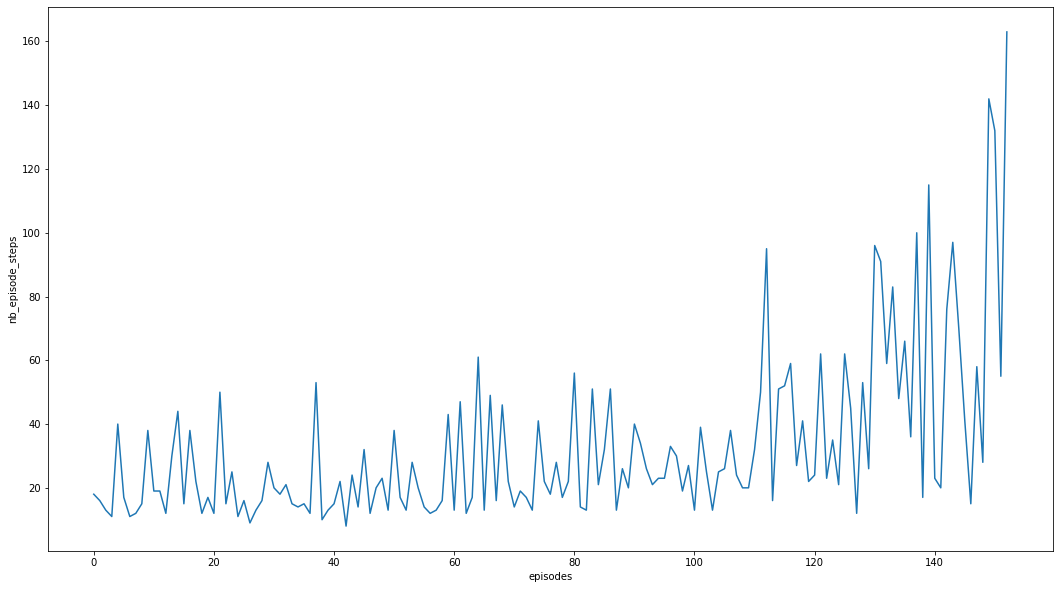

In [9]:
# Visualize the history for number of Training episode steps of the Cart Pole Game
plt.figure(figsize = (18,10))
plt.plot(history.history['nb_episode_steps'])
plt.ylabel('nb_episode_steps')
plt.xlabel('episodes')
plt.show()


## Test Agent

In [10]:
# Finally, evaluate and test our algorithm for 100 episodes.
dqn.test(env, nb_episodes=100, visualize=False)

Testing for 100 episodes ...
Episode 1: reward: 322.000, steps: 322
Episode 2: reward: 258.000, steps: 258
Episode 3: reward: 262.000, steps: 262
Episode 4: reward: 225.000, steps: 225
Episode 5: reward: 376.000, steps: 376
Episode 6: reward: 281.000, steps: 281
Episode 7: reward: 213.000, steps: 213
Episode 8: reward: 204.000, steps: 204
Episode 9: reward: 254.000, steps: 254
Episode 10: reward: 310.000, steps: 310
Episode 11: reward: 409.000, steps: 409
Episode 12: reward: 390.000, steps: 390
Episode 13: reward: 205.000, steps: 205
Episode 14: reward: 415.000, steps: 415
Episode 15: reward: 362.000, steps: 362
Episode 16: reward: 374.000, steps: 374
Episode 17: reward: 193.000, steps: 193
Episode 18: reward: 197.000, steps: 197
Episode 19: reward: 214.000, steps: 214
Episode 20: reward: 196.000, steps: 196
Episode 21: reward: 231.000, steps: 231
Episode 22: reward: 344.000, steps: 344
Episode 23: reward: 220.000, steps: 220
Episode 24: reward: 210.000, steps: 210
Episode 25: reward: 

In [11]:
# After training is done, we save the final weights.
dqn.save_weights('dqn_weights.h5f', overwrite=False)

For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right.<br>
Each action returns the new observation, the current reward, an indicator of whether the game ends, and some additional information.<br>
The next action is based on these values returned from the current step.<br>
The game ends when the pole is significantly tilted or you balance the pole for 500 steps.<br> 
The model gets 1 reward for each step it takes before the game ends.<br>


In [12]:
observation = env.reset()
dqn.load_weights('dqn_weights.h5f')
action = dqn.forward(observation)

print("Observation: ", observation)
print("Chosen action: ", action)

new_observation, reward, done, info = env.step(action)
print("Observations after action: ", new_observation)
print("Reward for this step: ", reward)
print("Episode Completion: ", done)

Observation:  [ 0.00480088 -0.04045059 -0.02786937 -0.03081552]
Chosen action:  0
Observations after action:  [ 0.00399187 -0.23516202 -0.02848568  0.25294567]
Reward for this step:  1.0
Episode Completion:  False


# Task 2
### Demonstrate the effectiveness of the RL agent

Use the agent developed in Task 1 to play the game for 100 episodes, record the cumulative reward for each round, and plot its reward.<br>
The environment is reset at the start of each episode.<br>
Each cumulative reward is stored in a list and mapped out in the graph.<br>

In [13]:
num_episodes = 100
episode_results = []
dqn.load_weights('dqn_weights.h5f')
for i in range(1,num_episodes+1):
    # Reset environment at the beginning of each episode
    observation = env.reset()
    cumulative_reward = 0
    done = False

    while not done:
        # Agent takes action based on observation
        action = dqn.forward(observation)
        
        # Environment processes action and returns new observation, reward, and done flag
        new_observation, reward, done, info = env.step(action)

        # Update episode reward and observation for next step
        observation = new_observation
        cumulative_reward += reward
        
    print("Episode:", i, " Cumulative reward: ", cumulative_reward)
    episode_results.append(cumulative_reward)

Episode: 1  Cumulative reward:  500.0
Episode: 2  Cumulative reward:  424.0
Episode: 3  Cumulative reward:  443.0
Episode: 4  Cumulative reward:  232.0
Episode: 5  Cumulative reward:  500.0
Episode: 6  Cumulative reward:  419.0
Episode: 7  Cumulative reward:  310.0
Episode: 8  Cumulative reward:  207.0
Episode: 9  Cumulative reward:  177.0
Episode: 10  Cumulative reward:  247.0
Episode: 11  Cumulative reward:  336.0
Episode: 12  Cumulative reward:  327.0
Episode: 13  Cumulative reward:  248.0
Episode: 14  Cumulative reward:  226.0
Episode: 15  Cumulative reward:  291.0
Episode: 16  Cumulative reward:  284.0
Episode: 17  Cumulative reward:  197.0
Episode: 18  Cumulative reward:  335.0
Episode: 19  Cumulative reward:  492.0
Episode: 20  Cumulative reward:  472.0
Episode: 21  Cumulative reward:  214.0
Episode: 22  Cumulative reward:  320.0
Episode: 23  Cumulative reward:  308.0
Episode: 24  Cumulative reward:  308.0
Episode: 25  Cumulative reward:  241.0
Episode: 26  Cumulative reward:  2

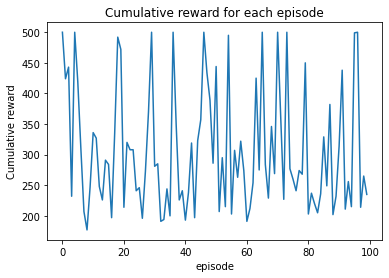

In [14]:
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [15]:
mean = sum(episode_results) / len(episode_results)
print("Average cumulative reward:", mean)
print("Is my agent good enough?", mean > 195)

Average cumulative reward: 306.01
Is my agent good enough? True


# Task 3
### Render an episode played by the developed RL agent (Only available in Google Colab)

In [18]:
!pip install pyvirtualdisplay
! pip install pyglet==1.5.27
!pip install pyopengl
from gym.wrappers import RecordVideo
import os
os.environ["PYGLET_NO_AVLIB"] = "1"
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
cumulative_reward = 0
while True:
    env.render()
    #your agent goes here
    action = dqn.forward(observation)
    observation, reward, done, info = env.step(action) 
    cumulative_reward += reward
    if done: 
      break; 
print('Current Episode Cumulative Reward:', cumulative_reward)   
env.close()
show_video()
     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Current Episode Cumulative Reward: 330.0
